In [1]:
!pip install box2d-py
!pip3 install box2d-py==2.3.8

In [2]:
from keras.layers import Dense,Activation
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib as mt
import gym

Using TensorFlow backend.


In [0]:
class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,n_actions,discrete=False):
    self.mem_size = max_size
    #self.input_shape = input_shape
    self.mem_cntr = 0
    self.discrete = discrete
    self.state_memory = np.zeros((self.mem_size,input_shape))
    self.new_state_memory = np.zeros((self.mem_size,input_shape))
    dtype = np.int8 if self.discrete else np.float32
    self.action_memory = np.zeros((self.mem_size,n_actions),dtype = dtype)
    self.reward_memory = np.zeros((self.mem_size))
    self.terminal_memory = np.zeros(self.mem_size,dtype = np.float32)

  def store_transition(self,state,action,reward,new_state,done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = new_state
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done)
    if self.discrete:
      actions = np.zeros(self.action_memory.shape[1])
      actions[action] = 1.0
      self.action_memory[index] = actions
    else:
      self.action_memory[index] = action
    self.mem_cntr +=1
  def sample_buffer(self,batch_size):
    max_mem = min(self.mem_cntr,self.mem_size)
    batch =np.random.choice(max_mem,batch_size)
    states = self.state_memory[batch]
    next_states = self.new_state_memory[batch]
    rewards = self.reward_memory[batch]
    actions = self.action_memory[batch]
    terminal = self.terminal_memory[batch]

    return states,actions,rewards,next_states,terminal
def build_dqn(lr,n_actions,input_dims,fc1_dims,fc2_dims):
  model = Sequential([
                      Dense(fc1_dims,input_shape=(input_dims,)),Activation('relu')
                      ,Dense(fc2_dims),Activation('relu'),Dense(n_actions)])
  model.compile(optimizer = Adam(lr=lr),loss='mse')
  return model
class Agent(object):
  def __init__(self,alpha,gamma,n_actions,epsilon, batch_size,input_dims,epsilon_dec = 0.99,epsilon_end = 0.01,mem_size = 1000000,fname = 'dqn_model'):
    self.action_space = [i for i in range(n_actions)]
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_dec = epsilon_dec
    self.epsilon_min = epsilon_end
    self.batch_size = batch_size 
    self.model_name = fname

    self.memory = ReplayBuffer(mem_size,input_dims,n_actions,discrete = True)
    self.q_eval = build_dqn(alpha,n_actions,input_dims,256,256)

  def remember(self,state,action,reward,new_state,done):
    self.memory.store_transition(state,action,reward,new_state,done)

  def choose_action(self,state):
    state = state[np.newaxis,:]
    rand = np.random.random()
    if rand <self.epsilon:
      action = np.random.choice(self.action_space)
    else:
      action = self.q_eval.predict(state)
      action = np.argmax(action)
    return action

  def learn(self):
    if self.memory.mem_cntr < self.batch_size:
      return
    state,action,reward,new_state,done = self.memory.sample_buffer(self.batch_size)
    #print(action)
    action_values = np.array(self.action_space,dtype = np.int8)
    action_indices = np.dot(action,action_values)

    q_eval = self.q_eval.predict(state)
    q_next = self.q_eval.predict(new_state)
    q_target = q_eval.copy()
    batch_index = np.arange(self.batch_size,dtype = np.int32)

    q_target[batch_index,action_indices] = reward + self.gamma*np.max(q_next,axis = 1)*done
    _ = self.q_eval.fit(state,q_target,verbose =0)
    

  def save_model(self):
    self.q_eval.save(self.model_file)
  def load_model(self):
    self.q_eval = load_model(self.model_file)
  
  def epsilon_decay(self):
    self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon> self.epsilon_min else self.epsilon_min


  







In [5]:
if __name__ =='__main__':
  agent = Agent(gamma = 0.99,epsilon = 1.0,alpha = 0.0005,input_dims = 8,n_actions = 4,mem_size=1000000,batch_size = 64,epsilon_end = 0.01)

  env = gym.make('LunarLander-v2')
  score_history = []
  epsilons = []
  n_episodes = 1000
  for i in range(n_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
      action = agent.choose_action(observation)
      next_state, reward, done, info = env.step(action)
      agent.remember(observation,action,reward,next_state,done)
      agent.learn()
      observation = next_state
      score+=reward
    score_history.append(score)
    agent.epsilon_decay()
    epsilons.append(agent.epsilon)
    print('episode',i,'score:',score)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode 0 score: -180.84330102531976
episode 1 score: -87.34007524437575
episode 2 score: -103.10478287442542
episode 3 score: -125.93458736872104
episode 4 score: -77.27150600811521
episode 5 score: -115.23906832698461
episode 6 score: -381.78335337511646
episode 7 score: -331.11356971031205
episode 8 score: -107.0114342633446
episode 9 score: -147.63555273431274
episode 10 score: -109.87517545148495
episode 11 score: -125.52634016387573
episode 12 score: -163.49461170601518
episode 13 score: -117.99126815810233
episode 14 score: -299.9859458058021
episode 15 score: -150.13263409448916
episode 16 score: -59.286486653926865
episode 17 score: -149.13553930113585
episode 18 score: -92.93011151601146
episode 19 score: -57.38459872373903
episode 20 score: -109.74196884832584
episode 21 score: -148.87241751929758
episode 22 score: -98.21453473531021
episode 23 score: -109.00022496474972
episode 24 score: -84.03145474024969
episode 25 score: -78.78292470964178
episode 26 score: -59.238952073

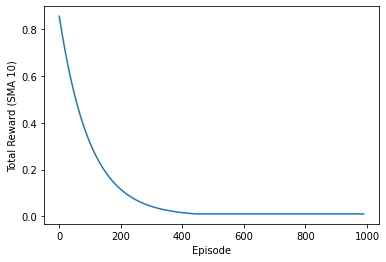

In [6]:
import matplotlib.pyplot as plt
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(epsilons[tr:tr+window]) for tr in range(window, len(epsilons))])

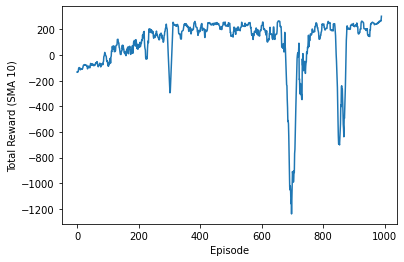

In [7]:
import matplotlib.pyplot as plt
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(score_history[tr:tr+window]) for tr in range(window, len(score_history))])